# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [50]:
# Add any additional import statements you need here
import warnings
import matplotlib.pyplot as plt

In [5]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/clairebentzen/Desktop/MDAS/ADS 509 - Applied Text Mining/Module 2/Assignment2.1/M1 Results/"

# Subfolders
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Specify artist_files for twitter data
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [8]:
# Read in the lyrics data
# Specify pathway to lyrics folder
lyrics_path = data_location + lyrics_folder

# Create a dataframe to store results
lyrics_data = pd.DataFrame(columns=['artist', 'song', 'lyrics'])

# Iterate through each file in the lyrics folder
for artist in os.listdir(lyrics_path):
    artist_path = os.path.join(lyrics_path, artist)
    
    # Iterate through each file in the artist folders
    for song in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song)
        rem_prefix = song.removeprefix(f'{artist}_')
        song_title = rem_prefix.removesuffix('.txt')

        # Open and read the contents of the file (song)
        with open(song_path, 'r') as file:
            contents = file.read()
            # Prepare data to add to dataframe
            data = {'artist': artist, 'song': song_title, 'lyrics': contents}
            # The df.append() function is deprecated, so we will ignore warnings here
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                # Append row of data to lyrics_df
                lyrics_data = lyrics_data.append(data, ignore_index=True)

In [10]:
# View lyrics_data dataframe
lyrics_data.head()

,artist,song,lyrics
0,robyn,includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [12]:
# Read in the twitter data
# Read cher twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

# Read robyn twitter data
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# Concat twitter dataframes
twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [24]:
# Keep only artist and description columns
twitter_data = twitter_data[['description', 'artist']]

In [26]:
# View twitter_data dataframe
twitter_data.head()

,description,artist
0,NaN,cher
1,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,csu,cher
4,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [28]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# Read positive words and add score column
pos_words = pd.read_csv('positive-words.txt', delimiter='\t', skiprows=35, header=None)
pos_words['score'] = 1
pos_words.columns.values[0] = 'word'

# Read negative words and add score column
neg_words = pd.read_csv('negative-words.txt', delimiter='\t', skiprows=35, header=None)
neg_words['score'] = -1
neg_words.columns.values[0] = 'word'

# Read tidytext sentiment
tidytext = pd.read_csv('tidytext_sentiments.txt', delimiter='\t')
tidytext.drop(columns='lexicon', inplace=True)
# Replace sentiment with -1 and 1
tidytext['score'] = tidytext['sentiment'].apply(lambda x: -1 if x == 'negative' else 1)
tidytext.drop(columns='sentiment', inplace=True)

# Combine dataframes
words = pd.concat([pos_words, neg_words, tidytext])

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [30]:
# Punctuation
punctuation = set(punctuation) # speeds up comparison

# Stopwords
sw = stopwords.words("english")

# Removes stopwords
def remove_stop(tokens):
    
    tokens = [word for word in tokens if word not in sw]
    
    return(tokens)
 
# Removes punctuation
def remove_punctuation(text, punct_set=punctuation): 
    
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenizes the text
def tokenize(text):     
    
    return text.split()

# Create function to calculate sentiment score
def calculate_score(text): 

    # Lower case
    text = str.lower(text)

    # Remove punctuation
    text = remove_punctuation(text)

    # Tokenize text
    tokens = tokenize(text)

    # Remove stopwords
    tokens = remove_stop(tokens)

    # sentiment_score will contain the total of sentiments for words found in the lexicon per song
    sentiment_score = 0
    # counter will contain the number of words that were actually found in the lexicon
    counter = 0

    # Add sentiments for words found in lexicon
    for word in tokens:
        if word in words['word'].values:
            counter += 1
            score = words.loc[words['word'] == word, 'score'].values[0]
            sentiment_score += score

    # Return average sentiment of the song, and return 0 if no words were found in the lexicon
    try:        
        return sentiment_score / counter
    except ZeroDivisionError:
        return 0

In [32]:
# Calculate sentiment scores for lyrics_data
lyrics_data['sentiment_score'] = lyrics_data['lyrics'].apply(calculate_score)

In [33]:
# Find average sentiment score by artist
lyrics_avg = lyrics_data.groupby('artist')['sentiment_score'].mean()
lyrics_avg

artist
cher     0.181567
robyn    0.282513
Name: sentiment_score, dtype: float64

Q: Overall, which artist has the higher average sentiment per song? 

A: Overall, Robyn has the highest average sentiment per song. The average for Robyn is 0.283 and the average for Cher is 0.182.

In [39]:
pd.set_option('display.max_colwidth', None)

# Subset cher lyrics
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']

# Get the top 3 scores
cher_top_3 = cher_lyrics.nlargest(3, 'sentiment_score')
cher_top_3

,artist,song,lyrics,sentiment_score
119,cher,mylove,"""My Love""\n\n\n\nWhen I go away\nI know my heart can stay with my love\nIt's understood\nEverywhere with my love\nMy love does it good, whoa\nMy love, oh only my love\nMy love does it good\n\nAnd when the cupboard's bare\nI'll still find something there with my love\nIt's understood\nEverywhere with my love\nMy love does it so good, whoa\nMy love, oh only my love\nMy love does it good\n\nOnly my love, oh only my love\nOnly my love, hold the other things to me\nOh, only my love, oh only my love\nOnly my love does it good to me\n\nEverywhere with my love\nDon't you see my love\nIt does it so good\nOh, only my love, only my love\nMy love does it good\n\nDon't ever ask me why\nI never say ""good-bye"" to my love\nIt's understood\n'Cause everywhere with my love\nMy love does it good, whoa\nOnly my love, oh only my love\nMy love does it good\n\nOh only my love\nOnly my love does it good to me,whoa\n",0.956522
407,cher,youwouldntknowlove,"""You Wouldn't Know Love""\n\n\n\nSo now you're back\nSo you had your fun\nAnd now you're coming around again\nSure baby, I should let you in\nSo you can let me down again\nWell, it doesn't really matter\nWhat you say or do\nYou can tell me that you love me\nBut I know it ain't true\n\n'Cause you wouldn't know love\nIf it knocked down your door\nYou wouldn't know it now\nYou never knew it before\nIf it landed in your hands\nFrom the Heavens above\nYou wouldn't know love\n(You wouldn't know love)\nNo, you wouldn't know love\n\nSaid you changed\nSaid you done me wrong\nBut you won't do it anymore\nNo darling, I don't have to tell you\nWhere I heard that line before\nBaby, you would say anything\nTo get back into my heart\nWhen it comes to loving\nYou don't even know where to start\n\n'Cause you wouldn't know love\nIf it knocked down your door\nYou wouldn't know it now\nYou never knew it before\nIf it landed in your hands\nFrom the Heavens above\nYou wouldn't know love\n(You wouldn't know love)\nNo, you wouldn't know love\n\nDid you think that I would believe\nAnything that you said\nLet you come back to me\nBaby, there's just no way\nBaby, I've had enough\nAnd you wouldn't know love\n\n (You wouldn't know love)\nYou wouldn't know love\nIf it knocked down your door\nYou wouldn't know it now\nYou never knew it before\nIf it landed in your hands\nFrom the Heavens above\nYou wouldn't know love\n(You wouldn't know love)\nNo, you wouldn't know love\n(You wouldn't know love)\nYou wouldn't know love\n\nYou wouldn't know love\nIf it knocked down your door\nYou wouldn't know it now\nYou never knew it before\nIf it landed in your hands\nFrom the Heavens above\nYou wouldn't know love\n(You wouldn't know love)\nNo, you wouldn't know love\n\nYou wouldn't know love\nIf it knocked down your door\nYou wouldn't know it now\nYou never knew it before\nIf it landed in your hands\nFrom the Heavens above\n",0.954545
355,cher,mylove318663,"""My Love""\n\n\n\nI heard you wanna be somebody\nBut you're already shining on me\nShe tried to make you feel so lonely\nBut you can be my one and only love\nMy love, my love\nYou can be my love\nMy love, my love\n\nYou've got the dreams to go on\nTake a step and look towards the sun\nIt doesn't matter where you've come from\nHere is where youâll always be the one\nMy love, my love\n\nYou're not alone\n'Cause I found a place where you can belong\nSomewhere you know you can run to\nSo if you need me to hold you\nYou can be my love\n\nIf you could only see what I see\nI'm dazzled by the beauty in front of me\nSo if you want to know how I feel\nI feel like you were meant to be my love\nMy love, my love\n\nYou're not alone\n'Cause I found a place where you can belong\nSomewhere you know you can run to\nSo if you need me to hold you\nYou can be my love\n\nYou can be my love\nYou can be my love\nYou can be my love\nYou can be my love\n\nSomewhere you know you can run to\nSo if you need me to hold you\nYou can be my love\n\n(My love, my lo

In [41]:
# Get the bottom 3 scores
cher_bottom_3 = cher_lyrics.nsmallest(3, 'sentiment_score')
cher_bottom_3

,artist,song,lyrics,sentiment_score
219,cher,skindeep,"""Skin Deep""\n\n\n\nYou came on to me a house of fire\nOne look was all it took for my desire\nI'm still burnin'\nIt's the middle of the night\nI need somethin'\nThat can make me feel alright as I go\n\nSkin deep, to the bone\nEvery time I see your face\nSkin deep, to the bone\nTellin' me that I'm in trouble\nS.O.S.\nI'm in distress, tonight\n\nKnock knock in the dark, what will I find?\nYour eyes, hypnotize but can they read my mind\nWatch your step now\nWe're gettin' closer to the edge\nThis is dangerous\nAnd all the lights are flashin' red as I go\n\nSkin deep, to the bone\nEvery time I see your face I go\nSkin deep, to the bone\nTellin' me that I'm in trouble\n\nSkin deep, to the bone\nEvery time I hear your voice I go\nSkin deep, to the bone\nTellin' me that I'm in trouble\nToo far gone\nI can't hold on, tonight, not tonight\n\nSkin deep, skin deep\nI'm still burnin'\nIt's the middle of the night\nI need someone\nWho can make me feel alright as I go\n\nSkin deep, to the bone\nEvery time I see your face I go\nSkin deep, to the bone\nTellin' me that I'm in trouble\n\nSkin deep, to the bone\nEvery time I see your face I go\nSkin deep, to the bone\nTellin' me that I'm in trouble\n\nSkin deep, to the bone\nEvery time I hear your voice I go\nSkin deep, to the bone\nTellin' me that I'm in trouble\nSkin deep, to the bone\n",-1.000000
324,cher,chiquititaspanishversion,"""Chiquitita (Spanish Version)""\n\n\n\nChiquitita, dime por quÃ©\nTu dolor hoy te encadena\nEn tus ojos hay, una sombra de gran pena\nNo quisiera verte asÃ­\nAunque quieras disimularlo\nSi es que tan triste estÃ¡s para quÃ© quieres callarlo\n\nChiquitita, dÃ­melo tu\nEn mi hombro, aquÃ­ llorando\nCuenta conmigo ya, para asÃ­ seguir andando\nTan segura te conocÃ­\nY ahora tu ala quebrada\nDÃ©jamela arreglar, yo la quiero ver curada\n\nChiquitita, sabes muy bien\nQue las penas vienen y van y desaparecen\nOtra vez vas a bailar\nY serÃ¡s feliz\nComo flores que florecen\nChiquitita, no hay que llorar\nLas estrellas brillan por ti allÃ¡ en lo alto\nQuiero verte sonreÃ­r\nPara compartir\nTu alegrÃ­a, Chiquitita\nOtra vez quiero compartir\nTu alegrÃ­a, Chiquitita\n\nChiquitita, no hay que llorar\nQuiero verte sonreÃ­r\nPara compartir tu alegrÃ­a\nHey, Chiquitita\n\nChiquitita, sabes muy bien\nQue las penas vienen y van y desaparecen\nOtra vez vas a bailar\nY serÃ¡s feliz\nComo flores que florecen\nChiquitita, no hay que llorar\nLas estrellas brillan por ti allÃ¡ en lo alto\nQuiero verte sonreÃ­r\nPara compartir\nTu alegrÃ­a, Chiquitita\nOtra vez quiero compartir\nTu alegrÃ­a, Chiquitita\nOtra vez quiero compartir\nTu alegrÃ­a, Chiquitita\n",-1.000000
344,cher,crymyselftosleep,"""Cry Myself To Sleep""\n\n\n\nEvery night, I lay my head\nOn my pillow on my bed\nAnd I just cry myself to sleep\n\nI know I shouldn't cry\nOver words that were all lies\nBut still, I cry myself to sleep\n\nEach night, I fight the tears\nBut still they fall\nAnd all the memories linger on\nHe's gone, he's gone\nAnd now there's nothing but to cry\nCry myself to sleep\nStill, I cry myself to sleep\n\nEach night, I fight those tears\nBut still, they fall\nAnd all the memories linger on\nHe's gone, he's gone, he's gone\nAnd now there's nothing but to cry\nAh, cry myself to sleep\nAh, cry myself to sleep\nAh, cry myself to sleep\n",-0.888889


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Cher's top 3 and bottom 3 songs based on sentiment are printed above. For the positive sentiment songs (My Love, You Wouldn't Know Love, and My Love 318663), the lyrics include the word love repeatedly which probably drives the positive sentiment. For the negative sentiment songs (Skin Deep, Chiquititas Spanish version, and Cry Myself to Sleep), the lyrics include words such as fire, trouble, cry, dangerous, distress, and dark which drives the negative score. I think Chiquititas is mistakenly included in this list because it is in Spanish, so the sentiment is not accurately calculated.

In [44]:
# Subset robyn lyrics
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']

# Get the top 3 scores
robyn_top_3 = robyn_lyrics.nlargest(3, 'sentiment_score')
robyn_top_3

,artist,song,lyrics,sentiment_score
60,robyn,jagvetendejligrosa,"""Jag Vet En Dejlig Rosa""\n\n\n\nJag vet en dejlig rosa och vit som liljeblad\nNÃ¤r jag pÃ¥ henne tÃ¤nker sÃ¥ gÃ¶rs mitt hjÃ¤rta glad\nDess stÃ¤mma ger en hjÃ¤rtans trÃ¶st\nLik nÃ¤ktergalens blida rÃ¶st\nSÃ¥ fager och sÃ¥ ljuv\n\nSom solen fagert skiner Ã¤r hon som purpur klar\nGud lÃ¥t dig aldrig sÃ¶rja men alltid vara glad\nMÃ¥ de fÃ¥ komma samman\nMed hjÃ¤rtans frÃ¶jd och gamman\nSom lÃ¤ngta till varann\n\nVar dag gÃ¥r solen neder och dagelig uppgÃ¥r\nNÃ¤r kommer dagen blider att jag dig skÃ¥da fÃ¥r\nI hÃ¥gen Ã¤r du jÃ¤mt mig nÃ¤r\nFarvÃ¤l, farvÃ¤l min hjÃ¤rtans kÃ¤r\nMÃ¥ngtusende godnatt\n",1.0
64,robyn,babyforgiveme,"""Baby Forgive Me""\n\n\n\nHere come the night\nIn your eyes\nBaby, be brave\nBe wise\nIt's up to you\nYou do what you like, mmm\nWon't you give it a chance, baby?\nJust one more try\n\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\n\n(Won't you give it a chance, baby?)\nWon't you give it a chance, baby?\nJust one more try\nOne more try\nYeah, eh\n\nYou got the power\nYou set the price\nBut baby, be fair\nBe nice\nYou say you want to be happy\nThen you got to put your love on the line\nJust let me make you smile again, baby\nI know we can work it out\nYes, I know we can\n\nBaby forgive me\nYeah\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\nBaby forgive me\n",1.0
67,robyn,monument,"""Monument""\n\n\n\nMake a space\nFor my body\nDig a hole\nPush the sides apart\nThis is what\nI'm controlling\nIt's a moat\nThe inside that I carve\n\nThis will my monument\nThis will be a beacon when I'm gone\nGone, gone\nWhen I'm gone\nGone, gone\nWhen I'm gone\n\nSo that when the moment comes\nI can say I did it all with love\nLove, love\nAll with love\nLove, love\nAll with love\n\nMake a cast\nOf my body\nPull back out\nSo that I can see\nLet go of\nHow you knew me\nLet go of\nWhat I used to be\n\nI will let this monument\nRepresent a moment of my life\nLife, life\nOf my life\nLife, life\nOf my life\n\nI will let this monument\nRepresent a moment of my life\nLife, life\nOf my life\nLife, life\nOf my life\n\nMake a cast\nOf my body\nPull back out\nSo that I can see\nLet go of\nHow you knew me\nLet go of\nWhat I used to be\n",1.0


In [46]:
# Get the bottom 3 scores (I print the top 4 because 2 of them are the same)
robyn_bottom_3 = robyn_lyrics.nsmallest(4, 'sentiment_score')
robyn_bottom_3

,artist,song,lyrics,sentiment_score
53,robyn,dontfuckingtellmewhattodo,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shopping's killing me\nMy ego is killing me\nCan't sleep, it's killing me\nMy label's killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriend's killing me\nMy talking's killing me\nKilling me\nKilling me\n\nCan't sleep, it's killing me\nMy dreams are killing me\nTV is killing me\nMy talking's killing me\nLet go, you're killing me\nEase up, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up, you're killing me\nLet go, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do, do, do, do, do\nDon't fucking tell me what to do\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do, do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\nDon't fucking tell me what to do\n",-0.883495
75,robyn,dontfuckingtellmewhattodo114520,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\nMy drinking is killing me\n\nMy smoking is killing me\nMy diet is killing me\nMy heels are killing me\nMy shopping's killing me\nMy ego is killing me\nCan't sleep, it's killing me\nMy label's killing me\nKickdrum\n\nMy phone is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy boss is killing me\nThe TV is killing me\nYour nagging is killing me\nMy boyfriend's killing me\nMy talking's killing me\nKilling me\nKilling me\n\nCan't sleep, it's killing me\nMy dreams are killing me\nTV is killing me\nMy talking's killing me\nLet go, you're killing me\nEase up, you're killing me\nCalm down, you're killing me\nMy god, you're killing me\n\nMy drinking is killing me\nMy smoking is killing me\nMy head is killing me\nMy mind is killing me\nMy back is killing me\nMy neck is killing me\nYour nagging is killing me\nMy gut is killing me\nMy PMS is killing me\nMy email is killing me\nThese hours are killing me\nMy tour is killing me\nThis flight is killing me\nMy manager's killing me\nMy mother's killing me\nMy landlord's killing me\nMy smoking is killing me\nThe TV is killing me\nYour nagging is killing me\nEase up, you're killing me\nLet go, you're killing me\nCalm down, you're killing

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Robyn's top 3 and bottom 3 songs based on sentiment are printed above. For the positive sentiment songs (Jag Vet En Dejlig Rosa, Baby Forgive Me, and Monument), the lyrics include the words power, love, forgive, monument, and smile which probably drives the positive sentiment. I think Jag Vet En Dejlig Rosa is mistakenly included in this list because it is in Spanish, so the sentiment is not accurately calculated. For the negative sentiment songs (Don't Fucking Tell Me What To Do, Criminal Intent, and Crash and Burn Girl), the lyrics include words such as killing, criminal, hurt, crash, and burn which drives the negative score.

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

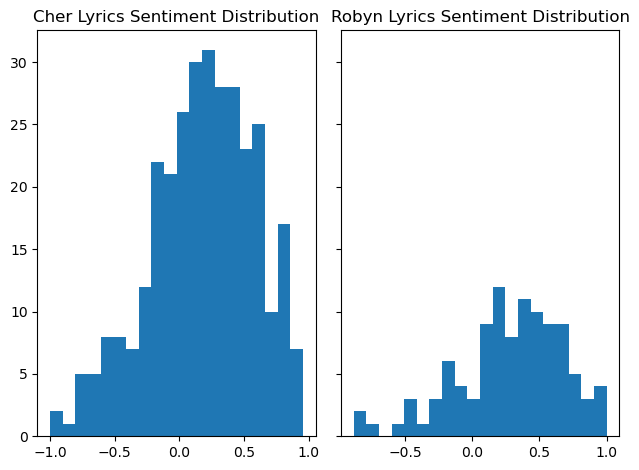

In [68]:
# Set fig, axs
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# Plot Cher distribution
axs[0].hist(cher_lyrics['sentiment_score'], bins=20)
axs[0].set_title('Cher Lyrics Sentiment Distribution')

# Plot Robyn distribution
axs[1].hist(robyn_lyrics['sentiment_score'], bins=20)
axs[1].set_title('Robyn Lyrics Sentiment Distribution')

plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [135]:
# your code here
data = {'emoji': ['😂', '❤️', '😭', '😍', '✨', '♥️', '😊', '😔', '💕', '😘', 
                  '😒', '😩', '😁', '🔥', '💔', '😢', '😳', '😡', '😞', '😑', '🙃'],
        'score': [1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 
                  -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1]}
emojis = pd.DataFrame(data)

In [137]:
# Checks if contains emojis
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)

# Check which twitter descriptions have emojis
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

In [138]:
twitter_data = twitter_data[twitter_data['has_emoji']==True]

In [141]:
# Create function to calculate sentiment score with emojis
def calculate_score_emojis(text): 

    # Lower case
    text = str.lower(text)

    # Remove punctuation
    text = remove_punctuation(text)

    # Tokenize text
    tokens = tokenize(text)

    # Remove stopwords
    tokens = remove_stop(tokens)

    # 
    sentiment_score = 0
    
    for word in tokens:
        if word in emojis['emoji'].values:
            score = emojis.loc[emojis['emoji'] == word, 'score'].values[0]
            sentiment_score += score
            
    return sentiment_score / len(tokens)

Q: What is the average sentiment of your two artists? 

A: <!-- Your answer here --> 

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: <!-- Your answer here --> 



In [143]:
#
twitter_data['sentiment_score'] = twitter_data['description'].apply(calculate_score_emojis)
twitter_data

In [147]:
twitter_avg = twitter_data.groupby('artist')['sentiment_score'].mean()
twitter_avg

artist
cher     0.014761
robyn    0.013571
Name: sentiment_score, dtype: float64